# Set up workspace

## Functions and packages

In [1]:
import copy
import pickle
from xmlrpc.client import Error

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from main_simulations import predinv_diff_m
from lotkavolterra_model import LotkaVolterraModel, BaseLotkaVolterraModel
from scipy.interpolate import interp1d, PchipInterpolator

plt.rcParams['font.family'] = 'Liberation Sans'
plt.rcParams['svg.fonttype'] = 'none'

data_path_dict = {'cr': './cr/', 'lv': './lv/'}


def plot_communities(comm_compo, x_values=None, log_frac=False, norm='log', sp_colors=None, **kwarg):
    """
    plot a list of community structure as stacked bar plot.
    
    :param comm_list: list, each entry is a dictionary recording composition of one single community (key: species name, value: CFU/5uL)
    :param x_values: list, tag for each community in the list
    :param log_frac: bool, if True log transform colony counting data
    :param kwarg: pass on to matplotlib.pyplot.bar()
    """
    # comm_list = np.array(comm_list).flatten()
    # ncomm = comm_list.size
    # splist = comm_list[0].keys()
    # if x_values is None:
    #     x_values = np.arange(ncomm)+1
    # 
    # ax = plt.gca()
    # 
    # comm_compo = np.array([[comm[sp] for sp in splist] for comm in comm_list])  # ncomm * nspe
    
    ncomm, nspe = comm_compo.shape
    if x_values is None:
        x_values = np.arange(ncomm)+1
    splist = np.arange(nspe)
    if sp_colors is None:
        sp_colors = [mpl.cm.tab10(i % 10) for i in range(nspe)]
    
    ax = plt.gca()
    
    if log_frac:
        data = np.log10(comm_compo + 1)
    else:
        if norm == 'log':
            data = comm_compo / np.sum(comm_compo, axis=1).reshape((ncomm,1)) * np.log10(np.sum(comm_compo, axis=1).reshape((ncomm,1)) + 1)
        elif norm == 'linear':
            data = comm_compo / np.sum(comm_compo, axis=1).reshape((ncomm,1))
        else:
            data = comm_compo
        
    data[np.isnan(data)] = 0
    
    curr_bottom = np.zeros((ncomm,))  # record current bar bottom position for stacked bar plot
    for isp,sp in enumerate(splist):
#         data = np.log10(comm_compo[:,isp]+1)
        data_1s = data[:,isp]
        ax.bar(x_values, data_1s, bottom=curr_bottom, label=sp, color=sp_colors[isp], **kwarg)
        curr_bottom += data_1s.flatten()
        
        
def draw_wave(series, day_list=None, day_list_labels=None, ax=None, line_color=mpl.colormaps['Oranges'](0.65), cbar=True):
    nday = series.shape[0]
    if day_list is None:
        day_list = np.arange(nday)
    else:
        if len(day_list) != nday:
            raise(ValueError, "`nday` doesn't match, `series` has {} days while `day_list` has {}".format(nday, len(day_list)))
    if day_list_labels is None:
        day_list_labels = day_list
    # 2D migrations
    if ax is None:
        fig = plt.figure(figsize=[4.8, 3], dpi=300)
        ax = plt.gca()
    else:
        fig = ax.figure
        plt.sca(ax)
        
    for iday in range(nday):
        day = day_list[iday]
        plt.plot(range(series.shape[1]), series[iday, :], '.-', label='day{}'.format(day),
                lw=3, mew=2, color=line_color, alpha=max(0.1, iday / nday))
    plt.xlabel('Well position $x$')
    plt.ylabel('Invader fraction $f$')
    # plt.legend()
    # create a color map
    # cmap = cm.ScalarMappable(norm=colors.Normalize(0, nday), cmap='Oranges')
    col_arr = np.zeros((nday, 4))
    col_arr[:, :3] = line_color[:-1]  # remove alpha
    alphas = np.arange(nday) / nday
    alphas[alphas < 0.1] = 0.1
    col_arr[:, -1] = alphas
    cmap = cm.ScalarMappable(norm=mpl.colors.Normalize(0, nday), cmap=mpl.colors.ListedColormap(col_arr))
    # create a colorbar
    if cbar:
        axins = ax.inset_axes([1.05, 0, 0.05, 1])
        hcbar = fig.colorbar(cmap, cax=axins, label='Time $n$ (day)')
        if day_list_labels is not None:
            hcbar.set_ticks(day_list_labels + 0.5)
            hcbar.set_ticklabels(day_list_labels)
        else: # move current tickposition up by 0.5
            curr_ticks = hcbar.get_ticks()
            hcbar.set_ticks(curr_ticks + 0.5)
            hcbar.set_ticklabels(curr_ticks)
            
        plt.sca(ax)
        return hcbar

        
def draw_v_n(series, thre=0.5, day_list=None, mean_ini=2, ax=None, **kwargs):
    # check if series is 2-dimensional np.array
    assert isinstance(series, np.ndarray), "`series` should be a 2D np.array"
    assert len(series.shape) == 2, "`series` should be a 2D np.array"
    
    # list of days
    nday = series.shape[0]
    if day_list is None:
        day_list = np.arange(nday)
    else:
        if len(day_list) != nday:
            raise(ValueError, "`nday` doesn't match, `series` has {} days while `day_list` has {}".format(nday, len(day_list)))

    # calculate instantaneous invasion speed v_n
    pos_thre = pos_above_thre(series, thre, np.arange(series.shape[1]))
    ws_vn = (pos_thre[1:] - pos_thre[:-1]) / (day_list[1:] - day_list[:-1])
    
    # create a new figure if ax is None
    if ax is None:
        fig = plt.figure(figsize=[4.8, 3], dpi=300)
        ax = plt.gca()
    else:
        fig = ax.figure
    plt.sca(ax)
    
    # set default kwargs for plotting waves
    kwargs.setdefault('alpha', 0.8)
    kwargs.setdefault('marker', '.')
    kwargs.setdefault('linestyle', '-')
    kwargs.setdefault('lw', 2)
    kwargs.setdefault('color', mpl.colormaps['Blues'](0.65))
    # plot instantaneous invasion speed v_n vs. day n
    plt.plot(day_list[1:], ws_vn, **kwargs)
    if mean_ini:  # if mean_iniday is not None, plot a horizontal line at the mean of v_n after mean_ini
        plt.plot(day_list[mean_ini + 1:], np.ones(nday - mean_ini - 1) * np.nanmean(ws_vn[mean_ini:]), 'k--', lw=kwargs['lw'], alpha=0.5)
    # plt.ylim([0, 1])
    # plt.xticks(day_list[1:])
    plt.xlabel('Time $n$')
    plt.ylabel('Instantaneous\n invasion speed $v_n$')
        
        
def pos_above_thre(distr, f_thre, pos=None):
    """
    Position of invader fraction first above threshold for multiple distributions
    Interpolate between two adjacent positions to get a continuous position

    :param distr: np.array of shape (n_mig, n_day, n_well), fraction of invader
    :param f_thre: threshold for measuring invasion speed
    :param pos: np.array of shape (n_well), position of wells
    :return: np.array of shape (n_mig, n_day), position of invader fraction first above threshold
    """
    if len(distr.shape) == 1:
        distr = distr.reshape(1, -1)

    if pos is None:
        pos = np.arange(1, distr.shape[1] + 1)

    distr_reversed = np.flip(distr, axis=1)
    idxs = distr.shape[1] - 1 - np.argmax(distr_reversed > f_thre,
                                          axis=1)  # the last well position idx that's above threshold
    mask = np.max(distr > f_thre, axis=1)

    x_0 = pos[idxs]
    x_1 = np.roll(pos, -1)[idxs]

    f_0 = np.take_along_axis(distr, idxs[:, None], axis=1).flatten()
    f_1 = np.take_along_axis(np.roll(distr, -1, axis=1), idxs[:, None], axis=1).flatten()

    x = np.where(mask, (f_0 - f_thre) / (f_0 - f_1) * (x_1 - x_0) + x_0, np.nan)
    x[idxs == distr.shape[1] - 1] = np.nan

    return x

def calc_inv_speed(series_allm, f_thre):
    """
    Calculate invasion speed for multiple distributions

    :param series_allm: np.array of shape (n_mig, n_day, n_well), fraction of invader
    :param f_thre: threshold for measuring invasion speed
    :return: np.array of shape (n_mig, n_day), instantaneous invasion speed
    """
    # if series_allm just has one migration rate, reshape it to check it is 3D
    if len(series_allm.shape) == 2:
        series_allm = series_allm.reshape(1, *series_allm.shape)
    vn_allm = np.zeros(series_allm.shape[:2])
    vn_allm[:, :] = np.nan
    for im in range(series_allm.shape[0]):
        series = series_allm[im, :]
        pos = pos_above_thre(series, f_thre)
        vn = pos[1:] - pos[:-1]
        vn_allm[im, 1:] = vn
    return vn_allm

def v_from_series(predinv_series, thre=0.5, skipdays=5):
    vn_allm = calc_inv_speed(predinv_series, f_thre=thre)
    return np.nanmean(vn_allm[:, skipdays:], axis=1)

## Load summarized simulated data
These files are already available in the depository.

In [2]:
model = 'cr'  # Consumer-Resource model
data_path = data_path_dict[model]
# properties of resident communities
with open(f'{data_path}sum_mod0rsd_20240212.pkl', 'rb') as f:
    sum_cr_mod0rsd = pickle.load(f)
# properties of invader communities
with open(f'{data_path}sum_mod0ivd_20240212.pkl', 'rb') as f:
    sum_cr_mod0ivd = pickle.load(f)
# competition curve
with open(f'{data_path}sum_mod1comp_20240215.pkl', 'rb') as f:
    sum_cr_mod1comp = pickle.load(f)
# simulated invasion
with open(f'{data_path}sum_mod2invasion_20240212.pkl', 'rb') as f:
    sum_cr_mod2invasion = pickle.load(f)
# predicted invasion
with open(f'{data_path}sum_mod3predinv_20240215.pkl', 'rb') as f:
    sum_cr_mod3predinv = pickle.load(f)
with open(f'{data_path}sum_mod3predinv2dim_20240215.pkl', 'rb') as f:
    sum_cr_mod3predinv2dim = pickle.load(f)
    
model = 'lv'  # Lotka-Volterra model
data_path = data_path_dict[model]
# properties of resident communities
with open(f'{data_path}sum_mod0rsd_20240216.pkl', 'rb') as f:
    sum_lv_mod0rsd = pickle.load(f)
# properties of invader communities
with open(f'{data_path}sum_mod0ivd_20240216.pkl', 'rb') as f:
    sum_lv_mod0ivd = pickle.load(f)
# competition curve
with open(f'{data_path}sum_mod1comp_20240216.pkl', 'rb') as f:
    sum_lv_mod1comp = pickle.load(f)
# simulated invasion
with open(f'{data_path}sum_mod2invasion_20240216.pkl', 'rb') as f:
    sum_lv_mod2invasion = pickle.load(f)
# predicted invasion
with open(f'{data_path}sum_mod3predinv_20240216.pkl', 'rb') as f:
    sum_lv_mod3predinv = pickle.load(f)
with open(f'{data_path}sum_mod3predinv2dim_20240216.pkl', 'rb') as f:
    sum_lv_mod3predinv2dim = pickle.load(f)

## Calculations

In [3]:
model_full_dict = {'lv': 'Lotka-Volterra Model', 'cr': 'Consumer Resource Model'}
for imod in range(2):
    model = ['cr', 'lv'][imod]
    model_full = model_full_dict[model]
    sum_mod0rsd = [sum_cr_mod0rsd, sum_lv_mod0rsd][imod]
    sum_mod1comp = [sum_cr_mod1comp, sum_lv_mod1comp][imod]
    sum_mod2invasion = [sum_cr_mod2invasion, sum_lv_mod2invasion][imod]
    sum_mod3predinv = [sum_cr_mod3predinv, sum_lv_mod3predinv][imod]
    sum_mod3predinv2dim = [sum_cr_mod3predinv2dim, sum_lv_mod3predinv2dim][imod]
    
    res_dict = {}
    var_dict = {}
    f_threshold = 0.5  # cutoff value for defining invasion speed
    
    # adding d0 data to mod2invasion
    nrsd, nivd = 100, 20
    var_dict['m_list_sim'] = copy.deepcopy(sum_mod2invasion[0, 0]['m_list'])
    (n_m, n_d, n_w, n_sp) = sum_mod2invasion[0, 0]['result'].shape
    var_dict['n_day_sim'] = n_d
    var_dict['n_well_sim'] = n_w
    for irsd in range(nrsd):
        for iivd in range(nivd):
            mod_cmb = sum_mod1comp[irsd, iivd]['mod_cmb']
            N_rsd = sum_mod1comp[irsd, iivd]['ini_abd_allNR'][1:mod_cmb.nS, 0] * 200
            N_ivd = sum_mod1comp[irsd, iivd]['ini_abd_allNR'][:1, -1] * 200
            if model == 'lv':
                R_sup = [1]
            else:
                R_sup = np.ones(mod_cmb.nR)
                R_sup[:3] = 1 / 3
            # load invasion results
            if sum_mod2invasion[irsd, iivd] is not None:
                res_mod2inv_d1plus = copy.deepcopy(sum_mod2invasion[irsd, iivd]['result'])
                res_mod2inv = np.zeros_like(res_mod2inv_d1plus)
                res_mod2inv[:, 1:, :, :] = res_mod2inv_d1plus[:, :-1, :, :]  # day 1 +
                res_mod2inv[:, 0, :10, :] = np.tile(np.concatenate((N_ivd, N_rsd * 0, R_sup)), (n_m, 10, 1))
                res_mod2inv[:, 0, 10:, :] = np.tile(np.concatenate((N_ivd * 0, N_rsd, R_sup)), (n_m, 10, 1))
                sum_mod2invasion[irsd, iivd]['result'] = copy.deepcopy(res_mod2inv)
    
    # simulated invasion speed
    vn_sim = np.zeros((nrsd, nivd, n_m, n_d))  # with 0.5 invader fraction cutoff
    vn_sim_range = np.zeros((nrsd, nivd, n_m, n_d, 2))  # with 0.4 and 0.6 cutoffs
    vn_sim.fill(np.nan)
    vn_sim_range.fill(np.nan)
    for irsd in range(nrsd):
        mod_rsd_curr = sum_mod0rsd[irsd]['mod_rsd']
        for iivd in range(nivd):
            data_curr = sum_mod2invasion[irsd, iivd]
            if data_curr is None:
                continue
            f_curr = data_curr['result'][:, :, :, 0] / np.sum(data_curr['result'][:, :, :, :mod_rsd_curr.nS + 1], axis=3)  # fraction of invader
            for im in range(n_m):
                vn_sim[irsd, iivd, im, :] = calc_inv_speed(f_curr[im, :, :], f_thre=f_threshold)
                vn_sim_range[irsd, iivd, im, :, 0] = calc_inv_speed(f_curr[im, :, :], f_thre=f_threshold - 0.1)
                vn_sim_range[irsd, iivd, im, :, 1] = calc_inv_speed(f_curr[im, :, :], f_thre=f_threshold + 0.1)
    res_dict['vn_sim'] = copy.deepcopy(vn_sim)
    res_dict['vn_sim_range'] = copy.deepcopy(vn_sim_range)
    
    # predicted invasion speed
    nrsd, nivd = 100, 20
    var_dict['m_list_pred'] = copy.deepcopy(sum_mod3predinv[0, 0]['m_list'])
    (n_m, n_d, n_w) = sum_mod3predinv[0, 0]['result'].shape
    var_dict['n_day_pred'] = n_d
    var_dict['n_well_pred'] = n_w
    vn_pred = np.zeros((nrsd, nivd, n_m, n_d))  # cutoff 0.5
    vn_pred_range = np.zeros((nrsd, nivd, n_m, n_d, 2))  # cutoffs 0.4, 0.6
    vn_pred.fill(np.nan)
    vn_pred_range.fill(np.nan)
    for irsd in range(nrsd):
        for iivd in range(nivd):
            data_curr = sum_mod3predinv[irsd, iivd]  # fraction of invader
            if data_curr is None:
                continue
            f_curr = data_curr['result']
            for im in range(n_m):
                vn_pred[irsd, iivd, im, :] = calc_inv_speed(f_curr[im, :, :], f_thre=f_threshold)
                vn_pred_range[irsd, iivd, im, :, 0] = calc_inv_speed(f_curr[im, :, :], f_thre=f_threshold - 0.1)
                vn_pred_range[irsd, iivd, im, :, 1] = calc_inv_speed(f_curr[im, :, :], f_thre=f_threshold + 0.1)
    res_dict['vn_pred'] = copy.deepcopy(vn_pred)
    res_dict['vn_pred_range'] = copy.deepcopy(vn_pred_range)
    
    # predicted invasion speed (2D)
    nrsd, nivd = 100, 20
    var_dict['m_list_pred2dim'] = copy.deepcopy(sum_mod3predinv2dim[0, 0]['m_list'])
    (n_m, n_d, n_w, n_sp) = sum_mod3predinv2dim[0, 0]['result'].shape
    var_dict['n_day_pred2dim'] = n_d
    var_dict['n_well_pred2dim'] = n_w
    vn_pred2dim = np.zeros((nrsd, nivd, n_m, n_d))
    vn_pred2dim.fill(np.nan)
    for irsd in range(nrsd):
        for iivd in range(nivd):
            data_curr = sum_mod3predinv2dim[irsd, iivd]
            if data_curr is None:
                continue
            f_curr = data_curr['result'][:, :, :, 0] / np.sum(data_curr['result'], axis=3)  # fraction of invader
            for im in range(n_m):
                vn_pred2dim[irsd, iivd, im, :] = calc_inv_speed(f_curr[im, :, :], f_thre=f_threshold)
    res_dict['vn_pred2dim'] = copy.deepcopy(vn_pred2dim)
    
    # diversity of resident community
    nrsd = 100
    div_alpha = np.zeros(nrsd)
    div_alpha.fill(np.nan)
    div_shannon = np.zeros(nrsd)
    div_shannon.fill(np.nan)
    for irsd in range(nrsd):
        data_curr = sum_mod0rsd[irsd]
        if data_curr is None:
            continue
        mod_rsd = sum_mod0rsd[irsd]['mod_rsd']
        NR_equil = sum_mod0rsd[irsd]['sol_rsd_daily'][:, -1]
        N_equil, R_equil = NR_equil[:mod_rsd.nS], NR_equil[mod_rsd.nS:]
        div_alpha[irsd] = mod_rsd.nS
        div_shannon[irsd] = np.exp(-np.sum(N_equil / np.sum(N_equil) * np.log(N_equil / np.sum(N_equil))))
    res_dict['rsd_div_alpha'] = copy.deepcopy(div_alpha)
    res_dict['rsd_div_shannon'] = copy.deepcopy(div_shannon)
    
    # prediction accuracy
    nrsd, nivd = 100, 20
    # sum of absolute difference between predicted and simulated invasion speed across all migration rates
    pred_err = np.nansum(np.abs(np.nanmean(res_dict['vn_sim'][:, :, :, 5:], axis=3) -
                                np.nanmean(res_dict['vn_pred'][:, :, :, 5:], axis=3)), axis=2)
    res_dict['pred_err'] = copy.deepcopy(pred_err)
    pred_err_allm = np.abs(np.nanmean(res_dict['vn_sim'][:, :, :, 5:], axis=3) -
                           np.nanmean(res_dict['vn_pred'][:, :, :, 5:], axis=3))
    res_dict['pred_err_allm'] = copy.deepcopy(pred_err_allm)
    
    # # influence of invader on resident community composition
    # var_dict['ini_mixfrac'] = copy.deepcopy(sum_mod1comp[0, 0]['mix_frac'])
    
    var_dict['ini_mixfrac'] = copy.deepcopy(sum_mod1comp[0, 0]['mix_frac'])
    
    # can only calculate for LotkaVolterraModel
    if isinstance(sum_mod1comp[0, 0]['mod_cmb'], LotkaVolterraModel):  
        # mean interaction towards invader
        mean_alpha = np.zeros((nrsd, nivd, len(var_dict['ini_mixfrac'])))
        mean_alpha.fill(np.nan)
        for irsd in range(nrsd):
            for iivd in range(nivd):
                data_comp = sum_mod1comp[irsd, iivd]
                if data_comp is None:
                    continue
                mod_cmb = data_comp['mod_cmb']
                fin_abd_rsd = data_comp['fin_abd_allNR'][1:mod_cmb.nS, :]
                mean_alpha[irsd, iivd, :] = mod_cmb._LotkaVolterraModel__A[0, 1:] @ fin_abd_rsd / fin_abd_rsd.sum(axis=0)
        res_dict['mean_alpha'] = copy.deepcopy(mean_alpha)

    # predicted critical invasion speed
    mcrit_pred = np.zeros((nrsd, nivd))
    mcrit_pred.fill(np.nan)
    for irsd in range(nrsd):
        for iivd in range(nivd):
            data_comp = sum_mod1comp[irsd, iivd]
            if data_comp is None:
                continue
            mod_cmb = data_comp['mod_cmb']
            ini_mixfrac = data_comp['mix_frac']
            ini_cfufrac = data_comp['ini_abd_allNR'][0, :] / np.sum(data_comp['ini_abd_allNR'][:mod_cmb.nS, :], axis=0)
            fin_cfufrac = data_comp['fin_abd_allNR'][0, :] / np.sum(data_comp['fin_abd_allNR'][:mod_cmb.nS, :], axis=0)
            K_ivd = data_comp['ini_abd_allNR'][0, -1] * data_comp['df']
            K_rsd = data_comp['ini_abd_allNR'][1:mod_cmb.nS, 0].sum() * data_comp['df']
            fin_mixfrac = data_comp['fin_abd_allNR'][0, :] / (data_comp['fin_abd_allNR'][0, :] + 
                                                              data_comp['fin_abd_allNR'][1:mod_cmb.nS, :].sum(axis=0) * K_ivd / K_rsd)
            below_thre_idxes = np.where(fin_mixfrac < f_threshold)[0]  # resitance only counts in parts of the curve that final invader fraction below threshold
            reverse_below_thre_idxes = np.where(1 - fin_mixfrac < f_threshold)[0]
            # if any(ini_mixfrac[below_thre_idxes] > fin_mixfrac[below_thre_idxes]):  # if there is any decrease in invader fraction in lower part of curve
            #     mcrit_pred[irsd, iivd] = np.max(ini_mixfrac[below_thre_idxes] - fin_mixfrac[below_thre_idxes])  # critical forward invasion speed
            #     if any(1 - ini_mixfrac[reverse_below_thre_idxes] > 1 - fin_mixfrac[reverse_below_thre_idxes]):  # if there is any decrease in resident fraction in lower part of the reverse curve
            #         mcrit_pred[irsd, iivd] = -np.max(1 - ini_mixfrac[reverse_below_thre_idxes] - (1 - fin_mixfrac[reverse_below_thre_idxes]))  # critical backward invasion speed
            if not any(ini_mixfrac[below_thre_idxes] > fin_mixfrac[below_thre_idxes]):  # if there is no decrease in invader fraction in lower part of curve
                mcrit_pred[irsd, iivd] = 0  #invader can invade at any speed
            elif not any(1 - ini_mixfrac[reverse_below_thre_idxes] > 1 - fin_mixfrac[reverse_below_thre_idxes]):  # if there is no decrease in resident fraction in lower part of the reverse curve
                mcrit_pred[irsd, iivd] = 0  #resident can backwards invade at any speed
            else:
                m_crit_forward = np.max(ini_mixfrac[below_thre_idxes] - fin_mixfrac[below_thre_idxes])  # critical forward invasion speed
                m_crit_backward = np.max(1 - ini_mixfrac[reverse_below_thre_idxes] - (1 - fin_mixfrac[reverse_below_thre_idxes]))  # critical backward invasion speed
                # depends on which gets over the pseudo "allee effect" first
                mcrit_pred[irsd, iivd] = np.where(m_crit_forward < m_crit_backward, m_crit_forward, -m_crit_backward)  # critical invasion speed
    res_dict['mcrit_pred'] = copy.deepcopy(mcrit_pred)
    
    if model == 'lv':
        res_dict_lv = copy.deepcopy(res_dict)
        var_dict_lv = copy.deepcopy(var_dict)
    elif model == 'cr':
        res_dict_cr = copy.deepcopy(res_dict)
        var_dict_cr = copy.deepcopy(var_dict)

/tmp/ipykernel_558911/2344733556.py:184: RuntimeWarning: divide by zero encountered in divide
  x = np.where(mask, (f_0 - f_thre) / (f_0 - f_1) * (x_1 - x_0) + x_0, np.nan)
/tmp/ipykernel_558911/1303861932.py:114: RuntimeWarning: divide by zero encountered in log
  div_shannon[irsd] = np.exp(-np.sum(N_equil / np.sum(N_equil) * np.log(N_equil / np.sum(N_equil))))
/tmp/ipykernel_558911/1303861932.py:114: RuntimeWarning: invalid value encountered in multiply
  div_shannon[irsd] = np.exp(-np.sum(N_equil / np.sum(N_equil) * np.log(N_equil / np.sum(N_equil))))


# Plotting

## Fig. 4c (Fig 4a,b were generated by codes for Sup Fig. 10)

/tmp/ipykernel_303838/420586634.py:179: RuntimeWarning: divide by zero encountered in divide
  x = np.where(mask, (f_0 - f_thre) / (f_0 - f_1) * (x_1 - x_0) + x_0, np.nan)


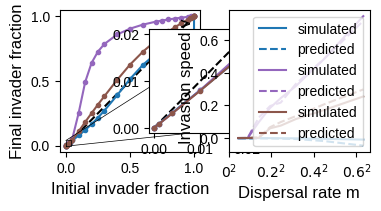

In [13]:
model = 'cr'
var_dict = var_dict_cr
sum_mod1comp = sum_cr_mod1comp
sum_mod2invasion = sum_cr_mod2invasion

ini_mixfrac = var_dict['ini_mixfrac']
sum_fin_mixfrac = np.zeros((100, 20, len(ini_mixfrac)))
m_list = var_dict['m_list_sim']
for irsd in range(100):
    for iivd in range(20):
        mod1comp = sum_mod1comp[irsd, iivd]
        mod_cmb = mod1comp['mod_cmb']
        ini_mixfrac = mod1comp['mix_frac']
        fin_abd_allN = mod1comp['fin_abd_allNR'][:mod_cmb.nS, :]
        ini_cfufrac = mod1comp['ini_abd_allNR'][0, :] / np.sum(mod1comp['ini_abd_allNR'][:mod_cmb.nS, :], axis=0)
        fin_cfufrac = mod1comp['fin_abd_allNR'][0, :] / np.sum(mod1comp['fin_abd_allNR'][:mod_cmb.nS, :], axis=0)
        ini_frac = ini_cfufrac
        Nivd2Nrsd = (ini_frac[1] * (1 - ini_mixfrac[1])) / ((1 - ini_frac[1]) * ini_mixfrac[1])
        f2mixf = lambda x: x / (x + Nivd2Nrsd * (1 - x))
        mixf2f = lambda x: Nivd2Nrsd * x / (Nivd2Nrsd * x + (1 - x))
        fin_mixfrac = f2mixf(fin_cfufrac)
        sum_fin_mixfrac[irsd, iivd, :] = fin_mixfrac
        
is_interest = np.array(np.where((0.0079 <= sum_fin_mixfrac[:, :, 4]) * (sum_fin_mixfrac[:, :, 4] <= 0.0081))).T[[0, 4, 10]]
fig, axes = plt.subplots(1, 2, figsize=[4, 2 - 0.15])
# axes[0]
plt.sca(axes[0])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Initial invader fraction', fontsize=12)
plt.ylabel('Final invader fraction', fontsize=12)
plt.xticks([0, 0.5, 1])
plt.yticks([0, 0.5, 1])
# add zoom in to axes[0], adjust posiiton
axins = axes[0].inset_axes([0.65, 0.1, 0.8, 0.8], transform=axes[0].transData)
axins.plot([0, 1], [0, 1], 'k--')
axins.set_xlim([-0.001, 0.021])
axins.set_ylim([-0.001, 0.021])
axins.set_xticks([0, 0.01, 0.02])
axins.set_yticks([0, 0.01, 0.02])
# axes[1]
for ii in range(len(is_interest)):
    irsd, iivd = is_interest[ii]
    color = color=mpl.colormaps['tab10']([0, 4, 5])[ii]
    plt.sca(axes[0])
    plt.plot(ini_mixfrac, sum_fin_mixfrac[irsd, iivd, :], '.-', color=color)
    
    axins.plot(ini_mixfrac, sum_fin_mixfrac[irsd, iivd, :], '.-', color=color)
    
    plt.sca(axes[1])
    mod_cmb = sum_mod1comp[irsd, iivd]['mod_cmb']
    series_sim = sum_mod2invasion[irsd, iivd]['result']
    v_arr = v_from_series(series_sim[:, :, :, 0] / np.sum(series_sim[:, :, :, :mod_cmb.nS], axis=3))
    plt.plot(np.sqrt(m_list), v_arr, color=color, label='simulated')
    plt.sca(axes[1])
    series_predinv = predinv_diff_m(ini_mixfrac, sum_fin_mixfrac[irsd, iivd, :], ini_mixfrac, m_list, nday=20, nwell=[10, 10], interp_method='pchip', save2file=None)
    predv_arr = v_from_series(series_predinv)
    plt.plot(np.sqrt(m_list), predv_arr, '--', color=color, label='predicted')
    plt.xlabel('Dispersal rate m', fontsize=12)
    plt.xticks([0, 0.2, 0.4, 0.6], ['$0^2$', '$0.2^2$', '$0.4^2$', '$0.6^2$'])
    plt.ylabel('Invasion speed v', fontsize=12)
plt.legend()

axes[0].plot([0, 0.04, 0.04, 0, 0], [0, 0, 0.04, 0.04, 0], 'k-', lw=0.5)
axes[0].plot([0, 0.65], [0.04, 0.1 + 0.35], 'k-', lw=0.5)
axes[0].plot([0.04, 0.65 + 0.35], [0, 0.1], 'k-', lw=0.5)

# plt.savefig(f'./figures/fig4_interaction_curve_sharedpoint.svg', bbox_inches='tight')

In [11]:
np.array(np.where((0.0079 <= sum_fin_mixfrac[:, :, 4]) * (sum_fin_mixfrac[:, :, 4] <= 0.0081)))

array([[18, 44, 48, 85],
       [19,  2,  3,  3]])

## Sup Fig. 10

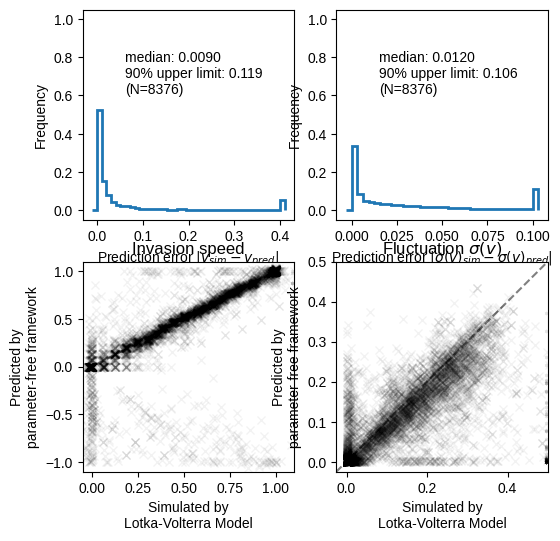

In [26]:
fig, axes = plt.subplots(2, 2, figsize=[6, 6])
plt.subplots_adjust(hspace=0.2, wspace=0.2)
for imod in range(2):
    model = ['cr', 'lv'][imod]
    res_dict = [res_dict_cr, res_dict_lv][imod]
    model_full = model_full_dict[model]
    
    mean_vn_sim = np.nanmean(res_dict['vn_sim'][:, :, :, 5:], axis=3)
    mean_vn_pred = np.nanmean(res_dict['vn_pred'][:, :, :, 5:], axis=3)
    std_vn_sim = np.nanstd(res_dict['vn_sim'][:, :, :, 5:], axis=3)
    std_vn_pred = np.nanstd(res_dict['vn_pred'][:, :, :, 5:], axis=3)
    mad_vn_sim = np.nanmedian(np.abs(res_dict['vn_sim'][:, :, :, 5:] - np.nanmedian(res_dict['vn_sim'][:, :, :, 5:], axis=3)[..., np.newaxis]), axis=3)
    mad_vn_pred = np.nanmedian(np.abs(res_dict['vn_pred'][:, :, :, 5:] - np.nanmedian(res_dict['vn_pred'][:, :, :, 5:], axis=3)[..., np.newaxis]), axis=3)
    # is_of_interest = mean_vn_sim >= -0.01
    is_of_interest = np.nanmin(mean_vn_sim, axis=2) >= -0.1
    is_of_interest = np.repeat(is_of_interest[:, :, np.newaxis], 8, axis=2)
    
    for ii in range(2): # 0 - mean, 1 - std
        # scatter
        plt.sca(axes[1, ii])
        plt.cla()
        if ii == 0:
            x_values = mean_vn_sim[is_of_interest]
            y_values = mean_vn_pred[is_of_interest]
            error = np.abs(mean_vn_sim - mean_vn_pred)[is_of_interest]
            plt.title('Invasion speed')
            plt.xlim([-0.05, 1.1])
            plt.ylim([-1.1, 1.1])
            # plt.savefig(f'./figures/supfig4_v_mean_pred_sim_{model}mod.svg', bbox_inches='tight')
        else:
            x_values = std_vn_sim[is_of_interest]
            y_values = std_vn_pred[is_of_interest]
            error = np.abs(std_vn_sim - std_vn_pred)[is_of_interest]
            plt.xlim([-0.025, 0.5])
            plt.ylim([-0.025, 0.5])
            plt.title('Fluctuation $\sigma(v)$')
            # plt.savefig(f'./figures/supfig4_v_std_pred_sim_{model}mod.svg', bbox_inches='tight')
        plt.plot([-1, 1], [-1, 1], '--', color=np.ones(3) * 0.5)
        plt.plot(x_values, 
                 y_values, 
                 'x', color='k', alpha=0.05)
        plt.xlabel(f'Simulated by\n{model_full}')
        plt.ylabel(f'Predicted by\nparameter-free framework')
    
        # plot outliers as *
        is_outlier = np.abs(x_values) > plt.ylim()[1]
        plt.plot(np.ones(is_outlier.sum()) * plt.ylim()[1] * 0.99, y_values[is_outlier], markersize=2.5, color='k', alpha=0.1,
                 linestyle='', marker=(6, 2, 0), mew=0.5)
    
        # histogram
        plt.sca(axes[0, ii])
        plt.cla()
        data = error
        if ii == 0:
            plt.xlabel('Prediction error $|v_{sim} - v_{pred}|$')
            bin_range = [0, 0.4]
            bin_width=0.01
        if ii == 1:
            plt.xlabel('Prediction error $|\sigma(v)_{sim} - \sigma(v)_{pred}|$')
            bin_range = [0, 0.1]
            bin_width=0.003
        hist_data = np.histogram(data, bins=np.linspace(*bin_range, int((bin_range[1] - bin_range[0]) / bin_width)))
        counts = hist_data[0]
        bins = hist_data[1]
        counts = np.concatenate([[np.sum(data < bin_range[0])], counts, [np.sum(data >= bin_range[1])]])
        bins = np.concatenate([[bin_range[0] - bin_width], bins, [bin_range[1] + bin_width]])
        plt.stairs(counts / counts.sum(), bins, lw=2)
        # annotate median, 95% CI, R2
        plt.annotate(f'median: {np.median(data):.4f}\n'
                     f'90% upper limit: {np.percentile(data, 90):.3f}\n'
                     # f'$R^2$: {r2_score(x_values.flatten(), y_values.flatten()):.2f}\n'
                     f'(N={np.sum(is_of_interest)})',
                     (0.2, 0.6), xycoords='axes fraction')
        plt.ylabel('Frequency')
        plt.ylim([-0.05, 1.05])
        
        # plt.savefig(f'./figures/supfig4_v_pred_sim_{model}mod.svg', bbox_inches='tight')

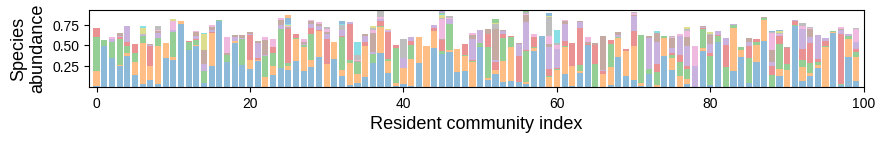

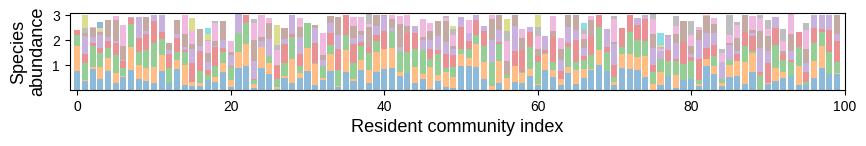

In [10]:
for imod in range(2):
    model = ['cr', 'lv'][imod]
    sum_mod0rsd = [sum_cr_mod0rsd, sum_lv_mod0rsd][imod]
    
    sp_abun_array = np.zeros((100, 20))  # 100 resident communities, 20 species
    for irsd in range(100):
        mod_rsd = sum_mod0rsd[irsd]['mod_rsd']
        NR_equil = sum_mod0rsd[irsd]['sol_rsd_daily'][:, -1]
        N_equil, R_equil = NR_equil[:mod_rsd.nS], NR_equil[mod_rsd.nS:]
        sp_abun_array[irsd, :mod_rsd.nS] = N_equil
    
    plt.figure(figsize=[10, 1])
    plot_communities(sp_abun_array, log_frac=False, x_values=range(100), norm='no', alpha=0.5)
    plt.xlim([-1, 100])
    plt.xlabel('Resident community index', fontsize=13)
    plt.ylabel('Species\nabundance', fontsize=13)
# plt.savefig(f'./figures/mod_resident_community_{model}mod.svg', bbox_inches='tight')

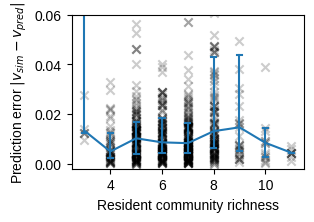

In [23]:
plt.figure(figsize=[3, 2])

for imod in range(2):
    model = ['cr', 'lv'][imod]
    res_dict = [res_dict_cr, res_dict_lv][imod]
    
    data = copy.deepcopy(res_dict['pred_err']) / 8
    mean_vn_sim = np.nanmean(res_dict['vn_sim'][:, :, :, 5:], axis=3)
    mean_vn_pred = np.nanmean(res_dict['vn_pred'][:, :, :, 5:], axis=3)
    data[np.nanmin(mean_vn_sim, axis=2) < 0] = np.nan
    
    plt.cla()
    plt.scatter(np.tile(res_dict['rsd_div_alpha'], (20, 1)).T, data, marker='x', color='k', alpha=0.2)
    rsd_div_alpha_values = np.arange(np.nanmin(res_dict['rsd_div_alpha']),
                                    np.nanmax(res_dict['rsd_div_alpha']) + 1)
    quartile_err_by_div_alpha = np.zeros((rsd_div_alpha_values.size, 3))
    for i in range(rsd_div_alpha_values.size):
        quartile_err_by_div_alpha[i, 1] = np.nanmedian(data[res_dict['rsd_div_alpha'] == rsd_div_alpha_values[i]])
        quartile_err_by_div_alpha[i, 0] = np.nanpercentile(data[res_dict['rsd_div_alpha'] == rsd_div_alpha_values[i]], 25)
        quartile_err_by_div_alpha[i, 2] = np.nanpercentile(data[res_dict['rsd_div_alpha'] == rsd_div_alpha_values[i]], 75)
        plt.plot([rsd_div_alpha_values[i], rsd_div_alpha_values[i]], 
                 [quartile_err_by_div_alpha[i, 0], quartile_err_by_div_alpha[i, 2]], 
                 '-', color=mpl.colormaps['tab10'](0))
        plt.plot([rsd_div_alpha_values[i] - 0.1, rsd_div_alpha_values[i] + 0.1], 
                 [quartile_err_by_div_alpha[i, 2], quartile_err_by_div_alpha[i, 2]], 
                 '-', color=mpl.colormaps['tab10'](0))
        plt.plot([rsd_div_alpha_values[i] - 0.1, rsd_div_alpha_values[i] + 0.1], 
                 [quartile_err_by_div_alpha[i, 0], quartile_err_by_div_alpha[i, 0]], 
                 '-', color=mpl.colormaps['tab10'](0))
    plt.plot(rsd_div_alpha_values, quartile_err_by_div_alpha[:, 1], mpl.colormaps['tab10'](0))
    plt.xlabel('Resident community richness')
    plt.ylabel('Prediction error $|v_{sim} - v_{pred}|$')
    plt.ylim([-0.002, 0.06])
    plt.xlim([np.nanmin(rsd_div_alpha_values) - 0.5, np.nanmax(rsd_div_alpha_values) + 0.5])
    # plt.savefig(f'./figures/supfig4_richness_pred_err_{model}mod_zoomin.svg', bbox_inches='tight')
    # plt.savefig(f'./figures/supfig4_richness_pred_err_{model}mod_zoomout.svg', bbox_inches='tight')

## Sup Fig. 11

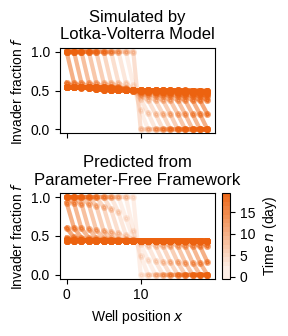

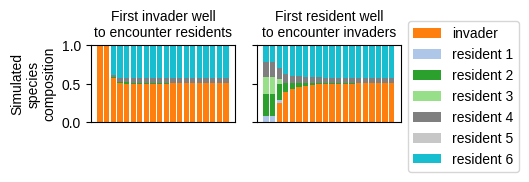

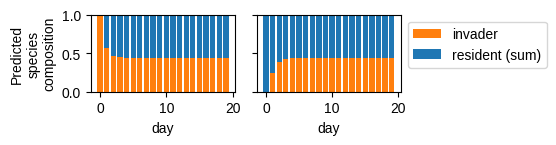

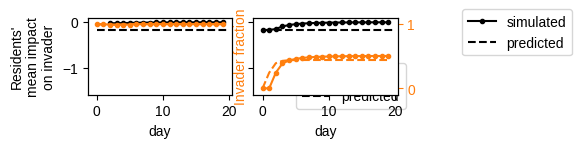

In [37]:
model = 'lv'
model_full = {'lv': 'Lotka-Volterra Model', 'cr': 'Consumer Resource Model'}[model]
sum_mod1comp = sum_lv_mod1comp
sum_mod2invasion = sum_lv_mod2invasion
sum_mod3predinv = sum_lv_mod3predinv
var_dict = var_dict_lv
inv_list = [[0, 4], [51, 18], [22, 4], [87, 18]]

plt_migs = np.array([5])
plt_days = np.arange(20)
plt_wells = np.arange(9, 11)

fig, axes = plt.subplots(2, 1, figsize=[2, 3], sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.7)
fig2, axes2 = plt.subplots(1, plt_wells.size, figsize=[2 * plt_wells.size, 1 * plt_migs.size], sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.15)
fig3, axes3 = plt.subplots(plt_migs.size, plt_wells.size, figsize=[2 * plt_wells.size, 1 * plt_migs.size], sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.15)
fig4, axes4 = plt.subplots(plt_migs.size, plt_wells.size, figsize=[2 * plt_wells.size, 1 * plt_migs.size], sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.15)

for iexp in range(len(inv_list)):
    irsd, iivd = inv_list[iexp]
    
    # load relevant data
    mod_cmb = sum_mod1comp[irsd, iivd]['mod_cmb']
    N_rsd = sum_mod1comp[irsd, iivd]['ini_abd_allNR'][1:mod_cmb.nS, 0] * 200
    N_ivd = sum_mod1comp[irsd, iivd]['ini_abd_allNR'][:1, -1] * 200
    R_sup = [1]
    m_list_sim = var_dict['m_list_sim']
    m_list_pred = var_dict['m_list_pred']
    
    res_mod1comp = sum_mod1comp[irsd, iivd]
    # res_mod2inv_d1plus = sum_mod2invasion[irsd, iivd]['result']
    # res_mod2inv = np.zeros_like(res_mod2inv_d1plus)
    res_mod2inv = sum_mod2invasion[irsd, iivd]['result']
    # res_mod2inv[:, 1:, :, :] = res_mod2inv_d1plus[:, :-1, :, :]  # day 1 +
    # res_mod2inv[:, 0, :10, :] = np.tile(np.concatenate((N_ivd, N_rsd * 0, R_sup)), (8, 10, 1))
    # res_mod2inv[:, 0, 10:, :] = np.tile(np.concatenate((N_ivd * 0, N_rsd, R_sup)), (8, 10, 1))
    res_mod3predinv = sum_mod3predinv[irsd, iivd]['result']  # day 1 +
    
# fig: plot predicted vs. simulated invasion waves
    for im in range(len(plt_migs)):
        for ii in range(2):
            if ii == 0:
                series_allm = res_mod2inv[:, :, :, 0] / res_mod2inv[:, :, :, :-1].sum(axis=3)
            elif ii == 1:
                series_allm = res_mod3predinv[:, :, :]
            
            mig = plt_migs[im]
            series = series_allm[mig, plt_days, :]
            # plot invasion waves
            plt.sca(axes[ii])
            plt.cla()
            draw_wave(series, ax=axes[ii], cbar=(ii == 1), day_list=plt_days, day_list_labels=plt_days[::5])
        
            plt.ylim([-0.05, 1.05])
            plt.yticks([0, 0.5, 1])
            if ii == 0:
                plt.xlabel('')
    axes[0].set_title(f'Simulated by\n{model_full}')
    axes[1].set_title('Predicted from\nParameter-Free Framework')
    # plt.suptitle(f'resident community {irsd} - invader {iivd}')
    
# fig2: plot border well composition change
    # visualize invasion as raw species composition change - simulated
    well_names = ['First invader well\nto encounter residents', 'First resident well\nto encounter invaders']
    colors_rsd = mpl.colormaps['tab20']([0, 1, 4, 5, 14, 15, 18, 19, 8, 9, 10, 11, 16, 17])[1:]
    colors_ivd = mpl.colormaps['tab20']([2])
    for iw in range(plt_wells.size):
        well = plt_wells[iw]
        mig = plt_migs[im]
        if plt_migs.size == 1:
            plt.sca(axes2[iw])
        else:
            plt.sca(axes2[im, iw])
        plt.cla()
        # all species composition (raw)
        plot_communities(res_mod2inv[mig, :20, well, :mod_cmb.nS], x_values=range(20), log_frac=False, norm='linear', alpha=1, 
                         sp_colors=np.concatenate([colors_ivd, colors_rsd[:mod_cmb.nS - 1]]))
        # # resident community composition (normed)
        # scaler = np.ones((1, mod_cmb.nS))
        # scaler[0, 0] = 0
        # plot_communities(scaler * inv_allNR_sim[im, :, well, :mod_cmb.nS], log_frac=False, norm='linear', alpha=0.5)
        # plt.plot(inv_allNR_sim[im, :, well, 1:mod_cmb.nS].sum(axis=1), 'k')
        if im == 0:
            # plt.title(f'well {well}')
            plt.title(well_names[iw], fontsize=10)
        if im == plt_migs.size - 1:
            plt.xlabel('day')
            plt.xlabel('')
            plt.xticks([])
        if iw == 0:
            # plt.ylabel(f'm = {sum_mod2invasion[irsd, iivd]["m_list"][mig]:.3f}')
            plt.ylabel('Simulated\nspecies\ncomposition')
            plt.yticks([0, 1])
            plt.ylim([0, 1])
    # fig2.suptitle(f'resident community {irsd} - invader {iivd}')
    plt.legend(np.concatenate([['invader'], [f'resident {isp + 1}' for isp in range(mod_cmb.nS - 1)]]), bbox_to_anchor=(1, 1.4), loc='upper left')
    
# fig3: plot border well composition change - predicted
    colors_rsd = mpl.colormaps['tab20']([0, 1, 4, 5, 14, 15, 18, 19, 8, 9, 10, 11, 16, 17])
    colors_ivd = mpl.colormaps['tab20']([2])
    for im in range(plt_migs.size):
        for iw in range(plt_wells.size):
            well = plt_wells[iw]
            mig = plt_migs[im]
            if plt_migs.size == 1:
                plt.sca(axes3[iw])
            else:
                plt.sca(axes3[im, iw])
            plt.cla()
            # all species composition (raw)
            plot_communities(np.concatenate([res_mod3predinv[mig, :, well, np.newaxis], 1 - res_mod3predinv[mig, :, well, np.newaxis]], axis=1), 
                             x_values=range(20), log_frac=False, norm='linear', alpha=1, 
                             sp_colors=np.concatenate([colors_ivd, colors_rsd[:mod_cmb.nS - 1]]))
            # # resident community composition (normed)
            # scaler = np.ones((1, mod_cmb.nS))
            # scaler[0, 0] = 0
            # plot_communities(scaler * inv_allNR_sim[im, :, well, :mod_cmb.nS], log_frac=False, norm='linear', alpha=0.5)
            # plt.plot(inv_allNR_sim[im, :, well, 1:mod_cmb.nS].sum(axis=1), 'k')
            if im == 0:
                plt.title(f'well {well}')
                plt.title('')
            if im == plt_migs.size - 1:
                plt.xlabel('day')
            if iw == 0:
                # plt.ylabel(f'm = {sum_mod2invasion[irsd, iivd]["m_list"][mig]:.3f}')
                plt.ylabel('Predicted\nspecies\ncomposition')
                plt.yticks([0, 1])
                plt.ylim([0, 1])
    # fig3.suptitle(f'resident community {irsd} - invader {iivd}')
    plt.legend(['invader', 'resident (sum)'], bbox_to_anchor=(1, 1), loc='upper left')
    
# fig4: plot resident community's impact on invader for border wells
    for im in range(plt_migs.size):
        for iw in range(plt_wells.size):
            well = plt_wells[iw]
            mig = plt_migs[im]
            mean_alpha = (mod_cmb.A[0, 1:] @ res_mod2inv[mig, :-1, well, 1:mod_cmb.nS].T) / res_mod2inv[mig, :-1, well, 1:mod_cmb.nS].sum(axis=1)
            mean_alpha_ini = (mod_cmb.A[0, 1:] @ res_mod2inv[mig, 0, -1, 1:mod_cmb.nS].T) / res_mod2inv[mig, 0, -1, 1:mod_cmb.nS].sum()
            
            if iexp == 0:
                ax_abun = axes4[iw].twinx()
            else:
                ax_abun.cla()
            color = 'tab:orange'
            ax_abun.plot((res_mod2inv[mig, :-1, well, 0:1].sum(axis=1) /  res_mod2inv[mig, :-1, well, :mod_cmb.nS].sum(axis=1)), '.-',
                         color=color, label='simulated')
            ax_abun.plot(res_mod3predinv[mig, :, well], '--',
                         color=color, label='predicted')
            # ax_abun.plot(res_mod2inv[mig, :, well, 1:mod_cmb.nS].sum(axis=1),
            #              color=color)
            ax_abun.set_ylim([-0.1, 1.1])
            if im == 0:
                # plt.title(well_names[iw], fontsize=10)
                pass
            if iw == plt_wells.size - 1:
                ax_abun.set_ylabel('Invader fraction', color=color)
                ax_abun.tick_params(axis='y', color=color, labelcolor=color)
                ax_abun.set_yticks([0, 1])
                plt.legend(['simulated', 'predicted'], bbox_to_anchor=(1.4, 0.5), loc='upper left')
            else:
                ax_abun.set_yticks([])
                
            plt.sca(axes4[iw])
            plt.cla()
            plt.plot(mean_alpha, 'k.-', label='simulated')
            plt.plot(np.arange(21), np.ones(21) * mean_alpha_ini, 'k--', label='predicted')
            plt.ylim([-1.6, 0.1])
            if iw == 0:
                plt.ylabel('Residents\'\nmean impact\non invader')
            else:
                plt.ylabel('')
            if iw == plt_wells.size - 1:
                plt.legend(['simulated', 'predicted'], bbox_to_anchor=(1.4, 1.2), loc='upper left')
            if im == plt_migs.size - 1:
                plt.xlabel('day')
            plt.xlim(-1.39, 20.39)
        # break
    # fig.savefig(f'./figures/demo_waves_irsd{irsd}_iivd{iivd}.svg', bbox_inches='tight')
    # fig2.savefig(f'./figures/demo_welldynamics_sim_rsd{irsd}_ivd{iivd}.svg', bbox_inches='tight')
    # fig3.savefig(f'./figures/demo_welldynamics_pred_rsd{irsd}_ivd{iivd}.svg', bbox_inches='tight')
    # fig4.savefig(f'./figures/demo_welldynamics_interaction_rsd{irsd}_ivd{iivd}.svg', bbox_inches='tight')

## Sup Fig. 12

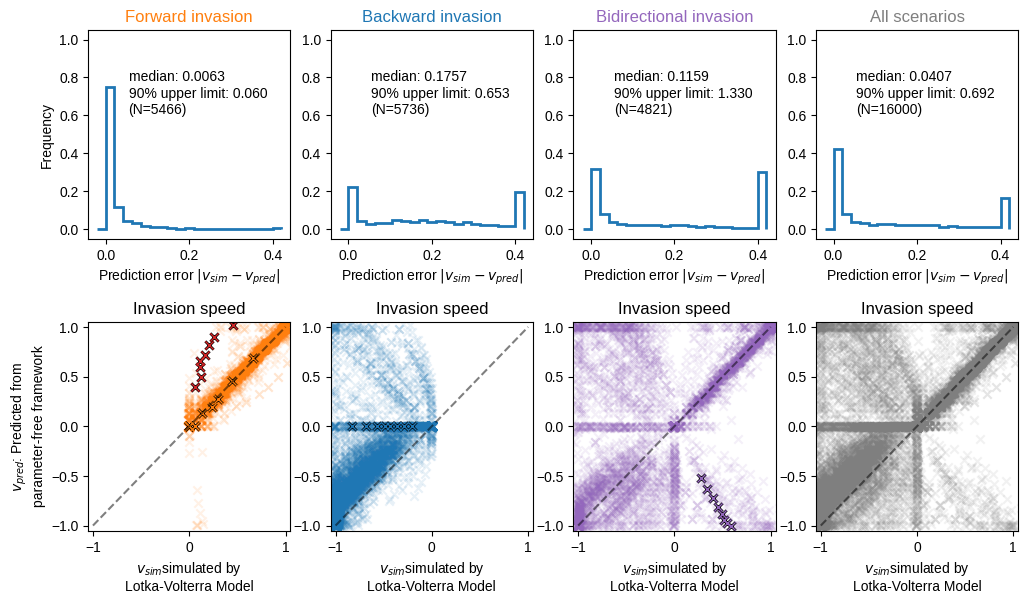

In [28]:
bin_width = 0.02
bin_range = [0, 0.4]
fig, axes = plt.subplots(2, 4, figsize=[12, 6.5])
plt.subplots_adjust(hspace=0.4)

for imod in range(2):
    model = ['cr', 'lv'][imod]
    res_dict = [res_dict_cr, res_dict_lv][imod]
    model_full = model_full_dict[model]
    vn_sim_range = res_dict['vn_sim_range']
    
    
    mean_vn_sim = np.nanmean(res_dict['vn_sim'][:, :, :, 5:], axis=3)
    mean_vn_pred = np.nanmean(res_dict['vn_pred'][:, :, :, 5:], axis=3)
    color_list = mpl.colormaps['tab10']([1, 0, 4, 7])
    for ii in range(4):
        # exclude splitted waves caused by coexistence
        is_coexistence = (np.abs(np.nanmean(vn_sim_range, axis=3)[:, :, :, 0] - np.nanmean(vn_sim_range, axis=3)[:, :, :, 1]) > 0.2)
        if ii == 0: # v_sim > 0
            is_of_interest = (np.min(mean_vn_sim, axis=2) >= -0.01)[:, :, np.newaxis] * ~is_coexistence
        elif ii == 1: # v_sim < 0
            is_of_interest = (np.max(mean_vn_sim, axis=2) <= 0.01)[:, :, np.newaxis] * ~is_coexistence
        elif ii == 2:
            is_of_interest = is_coexistence
        else:  # all
            is_of_interest = ~np.isnan(mean_vn_sim)#np.ones(mean_vn_sim.shape[:-1], dtype=bool)
        plt.sca(axes[0, ii])
        plt.cla()
        data = np.abs(mean_vn_sim[is_of_interest] - mean_vn_pred[is_of_interest])
        hist_data = np.histogram(data, bins=np.linspace(*bin_range, int((bin_range[1] - bin_range[0]) / bin_width)))
        counts = hist_data[0]
        bins = hist_data[1]
        counts = np.concatenate([[np.sum(data < bin_range[0])], counts, [np.sum(data >= bin_range[1])]])
        bins = np.concatenate([[bin_range[0] - bin_width], bins, [bin_range[1] + bin_width]])
        plt.stairs(counts / counts.sum(), bins, lw=2)
        # annotate median and statistics
        plt.annotate(f'median: {np.median(data):.4f}\n'
                     f'90% upper limit: {np.percentile(data, 90):.3f}\n'
                     f'(N={np.sum(is_of_interest)})',
                     (0.2, 0.6), xycoords='axes fraction')
        plt.xlabel('Prediction error $|v_{sim} - v_{pred}|$')
        if ii == 0:
            plt.ylabel('Frequency')
        plt.ylim([-0.05, 1.05])
        plt.title(['Forward invasion', 'Backward invasion', 'Bidirectional invasion', 'All scenarios'][ii], color=color_list[ii])
        
        plt.sca(axes[1, ii])
        plt.cla()
        plt.scatter(mean_vn_sim[is_of_interest], 
                    mean_vn_pred[is_of_interest], 
                    marker='x', color=color_list[ii], alpha=0.1)
        plt.plot([-1, 1], [-1, 1], 'k--', alpha=0.5)
        if model == 'lv':
            if ii == 0:  # addional example for forward invasion (wrong prediction)
                irsd, iivd = 51, 18
                plt.scatter(mean_vn_sim[irsd, iivd, :],
                            mean_vn_pred[irsd, iivd, :],
                            marker='x', color='k', lw=2)
                plt.scatter(mean_vn_sim[irsd, iivd, :],
                            mean_vn_pred[irsd, iivd, :],
                            marker='x', color=mpl.colormaps['tab10'](3), lw=1)
            if ii < 3:  # example for all scenarios
                irsd, iivd = np.array([[0, 4],
                                       [22, 4],
                                       [87, 18]])[ii]
                plt.scatter(mean_vn_sim[irsd, iivd, :],
                            mean_vn_pred[irsd, iivd, :],
                            marker='x', color='k', lw=2)
                plt.scatter(mean_vn_sim[irsd, iivd, :],
                            mean_vn_pred[irsd, iivd, :],
                            marker='x', color=color_list[ii], lw=1)
        plt.xlim([-1.05, 1.05])
        plt.ylim([-1.05, 1.05])
        plt.xlabel('$v_{sim} $'f'simulated by\n{model_full}')
        if ii == 0:
            plt.ylabel('$v_{pred}$: Predicted from\nparameter-free framework')
        plt.title('Invasion speed')
    # plt.savefig(f'./figures/v_pred_sim_all_{model}mod.svg', bbox_inches='tight')  # warning: large file size and slow rendering
    # plt.savefig(f'./figures/v_pred_sim_all_{model}mod.png', bbox_inches='tight', dpi=600)b

## Sup Fig. 13

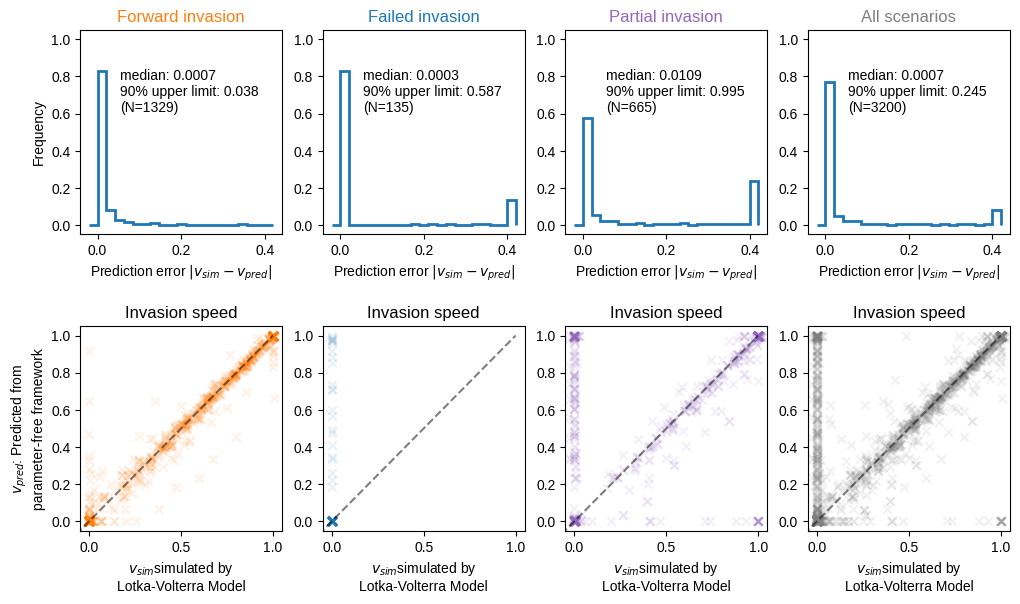

In [4]:
path = './lv/'

data_pred_dict = {}
data_sim_dict = {}
for thre in [0.4, 0.5, 0.6]:
    with open(f'{path}sum_vn_mod3predinv1dire_20240802_thre={thre}.pkl', 'rb') as f:
        data_pred_dict[thre] = pickle.load(f)
    with open(f'{path}sum_vn_mod2invasion1dire_20240802_thre={thre}.pkl', 'rb') as f:
        data_sim_dict[thre] = pickle.load(f)

bin_width = 0.02
bin_range = [0, 0.4]
model = 'lv'
model_full = {'lv': 'Lotka-Volterra Model', 'cr': 'Consumer Resource Model'}[model]

res_dict = {'vn_sim': data_sim_dict[0.5]['sum_vn'], 
            'vn_sim_low': data_sim_dict[0.4]['sum_vn'],
            'vn_sim_high': data_sim_dict[0.6]['sum_vn'],  
            'vn_pred': data_pred_dict[0.5]['sum_vn'],  
            'vn_pred_low': data_pred_dict[0.4]['sum_vn'],  
            'vn_pred_high': data_pred_dict[0.6]['sum_vn'],}

mean_vn_sim = np.nanmean(res_dict['vn_sim'][:, :, :, 5:], axis=3)
mean_vn_pred = np.nanmean(res_dict['vn_pred'][:, :, :, 5:], axis=3)
vn_sim_range = np.stack([res_dict['vn_sim_low'][:, :, :, 5:], res_dict['vn_sim_high'][:, :, :, 5:]], axis=-1)
vn_pred_range = np.stack([res_dict['vn_pred_low'][:, :, :, 5:], res_dict['vn_pred_high'][:, :, :, 5:]], axis=-1)
fig, axes = plt.subplots(2, 4, figsize=[12, 6.5])
fig.subplots_adjust(hspace=0.45)

color_list = mpl.colormaps['tab10']([1, 0, 4, 7])
for ii in range(4):
    # exclude splitted waves caused by coexistence
    is_coexistence = (np.abs(np.nanmean(vn_sim_range, axis=3)[:, :, :, 0] - np.nanmean(vn_sim_range, axis=3)[:, :, :, 1]) > 0.2)
    if ii == 0: # v_sim > 0
        is_of_interest = (np.min(mean_vn_sim, axis=2) >= 0)[:, :, np.newaxis] * ~is_coexistence
    elif ii == 1: # v_sim < 0
        is_of_interest = (np.max(mean_vn_sim, axis=2) <= 0)[:, :, np.newaxis] * ~is_coexistence
    elif ii == 2:
        is_of_interest = is_coexistence
    else:  # all
        is_of_interest = ~np.isnan(mean_vn_sim)#np.ones(mean_vn_sim.shape[:-1], dtype=bool)
    plt.sca(axes[0, ii])
    data = np.abs(mean_vn_sim[is_of_interest] - mean_vn_pred[is_of_interest])
    hist_data = np.histogram(data, bins=np.linspace(*bin_range, int((bin_range[1] - bin_range[0]) / bin_width)))
    counts = hist_data[0]
    bins = hist_data[1]
    counts = np.concatenate([[np.sum(data < bin_range[0])], counts, [np.sum(data >= bin_range[1])]])
    bins = np.concatenate([[bin_range[0] - bin_width], bins, [bin_range[1] + bin_width]])
    plt.stairs(counts / counts.sum(), bins, lw=2)
    # annotate median and statistics
    plt.annotate(f'median: {np.median(data):.4f}\n'
                 f'90% upper limit: {np.percentile(data, 90):.3f}\n'
                 f'(N={np.sum(is_of_interest)})',
                 (0.2, 0.6), xycoords='axes fraction')
    plt.xlabel('Prediction error $|v_{sim} - v_{pred}|$')
    if ii == 0:
        plt.ylabel('Frequency')
    plt.ylim([-0.05, 1.05])
    plt.title(['Forward invasion', 'Failed invasion', 'Partial invasion', 'All scenarios'][ii], color=color_list[ii])
    
    plt.sca(axes[1, ii])
    plt.scatter(mean_vn_sim[is_of_interest], 
                mean_vn_pred[is_of_interest], 
                marker='x', color=color_list[ii], alpha=0.1)
    plt.plot([-1, 1], [-1, 1], 'k--', alpha=0.5)
    plt.xlim([-.05, 1.05])
    plt.ylim([-.05, 1.05])
    plt.xlabel('$v_{sim} $'f'simulated by\n{model_full}')
    if ii == 0:
        plt.ylabel('$v_{pred}$: Predicted from\nparameter-free framework')
    plt.title('Invasion speed')
# plt.savefig(f'./figures/v_pred_sim_all_{model}mod.svg', bbox_inches='tight')  # warning: large file size and slow rendering
# plt.savefig(f'./figures/v_pred_sim_all_{model}mod_onesided.png', bbox_inches='tight', dpi=600)

## Sup Fig. 14

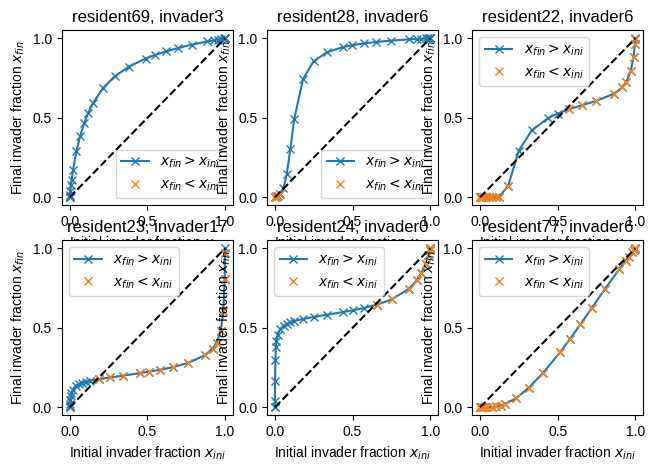

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(2.5 * 3, 5), sharex=False, sharey=False)
for imod in range(2):
    model = ['cr', 'lv'][imod]
    sum_mod1comp = [sum_cr_mod1comp, sum_lv_mod1comp][imod]
    
    # plt.subplots_adjust(hspace=0.4)
    inv_list = np.concatenate([np.random.choice(100, 20, replace=True),
                               np.random.choice(20, 20, replace=True)]).reshape([2, -1]).T
    if model == 'lv':
        inv_list = [[69, 3],
                    [28, 6],
                    [22, 6],
                    [23, 17],
                    [24, 0],
                    [77, 6]]
    elif model == 'cr':
        inv_list = [[33, 11],
                    [84, 11],
                    [79, 6],
                    [8, 18],
                    [56, 17],
                    [97, 2]]
    for ii in range(len(inv_list)):
        irsd, iivd = inv_list[ii]
        mod1comp = sum_mod1comp[irsd, iivd]
        mod_cmb = mod1comp['mod_cmb']
        fin_abd_allN = mod1comp['fin_abd_allNR'][:mod_cmb.nS, :]
        ini_cfufrac = mod1comp['ini_abd_allNR'][0, :] / np.sum(mod1comp['ini_abd_allNR'][:mod_cmb.nS, :], axis=0)
        fin_cfufrac = mod1comp['fin_abd_allNR'][0, :] / np.sum(mod1comp['fin_abd_allNR'][:mod_cmb.nS, :], axis=0)
        
        plt.sca(axes.flatten()[ii])
    
        plt.cla()
        
        # competition curve
        plt.plot(ini_cfufrac, fin_cfufrac, 'x-')
        plt.plot(ini_cfufrac[ini_cfufrac > fin_cfufrac], fin_cfufrac[ini_cfufrac > fin_cfufrac], 'x')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'resident{irsd}, invader{iivd}')
        plt.legend(['$x_{fin} > x_{ini}$', '$x_{fin} < x_{ini}$'])
        plt.xticks([0, 0.5, 1])
        plt.yticks([0, 0.5, 1])
        plt.xlabel('Initial invader fraction $x_{ini}$')
        plt.ylabel('Final invader fraction $x_{fin}$')
    # plt.savefig(f'./figures/sup4_demo_interaction_{model}mod.svg', bbox_inches='tight')

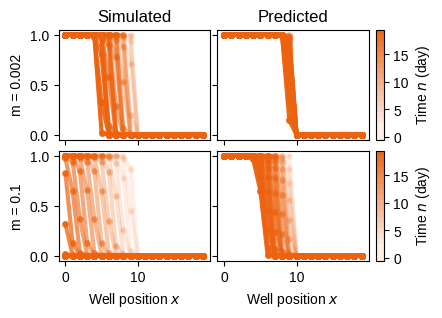

In [15]:
fig, axes = plt.subplots(2, 2, figsize=[4, 3], sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.1, wspace=0.05)
for imod in range(2):
    model = ['cr', 'lv'][imod]
    var_dict = [var_dict_cr, var_dict_lv][imod]
    sum_mod1comp = [sum_cr_mod1comp, sum_lv_mod1comp][imod]
    sum_mod2invasion = [sum_cr_mod2invasion, sum_lv_mod2invasion][imod]
    sum_mod3predinv = [sum_cr_mod3predinv, sum_lv_mod3predinv][imod]
    
    for i_exp in range(len(inv_list)):
        irsd, iivd = inv_list[i_exp]
        
        # load relevant data
        mod_cmb = sum_mod1comp[irsd, iivd]['mod_cmb']
        N_rsd = sum_mod1comp[irsd, iivd]['ini_abd_allNR'][1:mod_cmb.nS, 0] * 200
        N_ivd = sum_mod1comp[irsd, iivd]['ini_abd_allNR'][:1, -1] * 200
        R_sup = [1]
        m_list_sim = var_dict['m_list_sim']
        m_list_pred = var_dict['m_list_pred']
        
        res_mod1comp = sum_mod1comp[irsd, iivd]
        # res_mod2inv_d1plus = sum_mod2invasion[irsd, iivd]['result']
        # res_mod2inv = np.zeros_like(res_mod2inv_d1plus)
        res_mod2inv = sum_mod2invasion[irsd, iivd]['result']
        # res_mod2inv[:, 1:, :, :] = res_mod2inv_d1plus[:, :-1, :, :]  # day 1 +
        # res_mod2inv[:, 0, :10, :] = np.tile(np.concatenate((N_ivd, N_rsd * 0, R_sup)), (8, 10, 1))
        # res_mod2inv[:, 0, 10:, :] = np.tile(np.concatenate((N_ivd * 0, N_rsd, R_sup)), (8, 10, 1))
        res_mod3predinv = sum_mod3predinv[irsd, iivd]['result']  # day 1 +
        
        # plot predicted vs. simulated invasion waves
        plt_migs = np.array([0, 5])
        plt_days = np.arange(20)
        # plt_days = [0, 5, 10]
        for im in range(len(plt_migs)):
            for ii in range(2):
                if ii == 0:
                    series_allm = res_mod2inv[:, :, :, 0] / res_mod2inv[:, :, :, :mod_cmb.nS].sum(axis=3)
                elif ii == 1:
                    series_allm = res_mod3predinv[:, :, :]
                
                mig = plt_migs[im]
                series = series_allm[mig, plt_days, :]
                # plot invasion waves
                plt.sca(axes[im, ii])
                plt.cla()
                draw_wave(series, ax=axes[im, ii], cbar=(ii == 1), day_list=plt_days, day_list_labels=plt_days[::5])
            
                plt.ylim([-0.05, 1.05])
                plt.yticks([0, 0.5, 1])
                if im == 0:
                    plt.xlabel('')
                if ii > 0:
                    plt.ylabel('')
                else:
                    plt.ylabel(f'm = {m_list_sim[mig]}')
        axes[0, 0].set_title(f'Simulated')
        axes[0, 1].set_title('Predicted')
        # plt.suptitle(f'resident community {irsd} - invader {iivd}')
        # fig.savefig(f'./figures/sup4_demo_waves_{model}mod_irsd{irsd}_iivd{iivd}.svg', bbox_inches='tight')

## Sup Fig. 15

/tmp/ipykernel_28117/2009180543.py:32: RuntimeWarning: invalid value encountered in sqrt
  plt_fun = lambda x: np.sqrt(x)


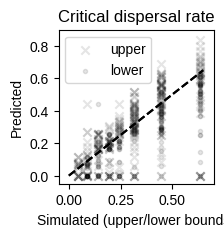

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(2, 2))
for imod in range(2):
    res_dict = [res_dict_cr, res_dict_lv][imod]
    sum_mod2invasion = [sum_cr_mod2invasion, sum_lv_mod2invasion][imod]
    
    # measured critical invasion speed
    mcrit_sim = np.zeros((nrsd, nivd))
    mcrit_sim.fill(np.nan)
    m_abovecrit_sim = np.zeros((nrsd, nivd))
    m_abovecrit_sim.fill(np.nan)
    m_belowcrit_sim = np.zeros((nrsd, nivd))
    m_belowcrit_sim.fill(np.nan)
    
    
    v_sim_all = np.nanmean(res_dict['vn_sim'][:, :, :, 5:], axis=3)
    for irsd in range(nrsd):
        for iivd in range(nivd):
            data_inv = sum_mod2invasion[irsd, iivd]
            if data_inv is None:
                continue
            m_list = data_inv['m_list']
            v_sim = v_sim_all[irsd, iivd, :]
            
            if (v_sim[0] < 0.01) * (v_sim[-1] > -0.01):
                m_belowcrit_sim[irsd, iivd] = m_list[np.where(v_sim < 0.01)[0][-1]]
                if v_sim[-1] > 0.01:
                    m_abovecrit_sim[irsd, iivd] = m_list[np.where(v_sim > 0.01)[0][0]]
    res_dict['mcrit_sim'] = copy.deepcopy(mcrit_sim)
    res_dict['m_belowcrit_sim'] = copy.deepcopy(m_belowcrit_sim)
    res_dict['m_abovecrit_sim'] = copy.deepcopy(m_abovecrit_sim)
    
    plt_fun = lambda x: np.sqrt(x)
    # plt.sca(axes[0])
    plt.cla()
    plt.scatter(plt_fun(res_dict['m_belowcrit_sim']), plt_fun(res_dict['mcrit_pred'] * 2), marker='x', alpha=0.1, color='k', label='upper')
    plt.plot([0, 0.65], [0, 0.65], 'k--')
    # plt.sca(axes[0])
    plt.scatter(plt_fun(res_dict['m_abovecrit_sim']), plt_fun(res_dict['mcrit_pred'] * 2), marker='.', alpha=0.1, color='k', label='lower')
    plt.plot([0, 0.65], [0, 0.65], 'k--')
    plt.xlabel('Simulated (upper/lower bounds)')
    plt.ylabel('Predicted')
    plt.legend()
    plt.xlim([-0.05, 0.7])
    plt.ylim([-0.05, 0.9])
    plt.title('Critical dispersal rate')
    # fig.savefig('./figures/cr_mcrit_pred_vs_sim.svg', dpi=300, bbox_inches='tight')

## Sup Fig. 16

In [45]:
# load functions: from sum_mod1comp[irsd, iivd] + m_list to predinv
def predinv_from_mod1comp(mod1comp, m_list, use_subset=None, method='linear'):
    """
    use_subset: None or list of indices to use
    """
    data = mod1comp
    mod_cmb = data['mod_cmb']
    ini_abd_allN = data['ini_abd_allNR'][:mod_cmb.nS, :]
    ini_abd_frac = ini_abd_allN[0, :] / ini_abd_allN.sum(axis=0)  # invader fraction
    fin_abd_allN = data['fin_abd_allNR'][:mod_cmb.nS, :]
    fin_abd_frac = fin_abd_allN[0, :] / fin_abd_allN.sum(axis=0)  # invader fraction
    ini_mix_frac = data['mix_frac']
    
    if use_subset is None:
        use_subset = np.arange(len(ini_mix_frac))
    else:
        use_subset = np.array(use_subset)
        
    predinv_series = predinv_diff_m(ini_abd_frac[use_subset], fin_abd_frac[use_subset], ini_mix_frac[use_subset], m_list, interp_method=method)
        
    return predinv_series

def v_from_series(predinv_series, thre=0.5, skipdays=5):
    vn_allm = calc_inv_speed(predinv_series, f_thre=thre)
    return np.nanmean(vn_allm[:, skipdays:], axis=1)

model = 'lv'
imod = ['cr', 'lv'].index(model)
var_dict = [var_dict_cr, var_dict_lv][imod]
res_dict = [res_dict_cr, res_dict_lv][imod]
sum_mod1comp = [sum_cr_mod1comp, sum_lv_mod1comp][imod]
sum_mod2invasion = [sum_cr_mod2invasion, sum_lv_mod2invasion][imod]
data_path = data_path_dict[model]
model_full = model_full_dict[model]

# load competition curve
# load simulation result
# define empty variables to store different prediction results
m_list = var_dict['m_list_sim']
npoint_max = var_dict['ini_mixfrac'].size
subset_list = [np.arange(npoint_max),  # subsets of points from mix_frac to predict v
               [0, 1, -1], 
               [0, 4, -1], 
               [0, 8, -1], 
               [0, 1, 8, -1], 
               [0, 1, 4, -1], 
               [0, 2, 8, -1], 
               [0, 1, 8, 14, -1],
               [0, 1, 2, 8, -1],
               [0, 2, 8, 14, -1],
               [0, 1, 8, 14, 18, -1],
               [0, 1, 2, 4, 8, -1],
               [0, 2, 8, 14, 18, -1],
               [0, 1, 4, 8, 14, 18, -1],
               [0, 1, 2, 4, 8, 14, -1], 
               [0, 2, 4, 8, 14, 18, -1]]
npoint_list = [len(subset) for subset in subset_list]
vn_pred_partial_curve = np.zeros((100, 20, len(m_list), len(subset_list)))
vn_pred_partial_curve.fill(np.nan)

mean_vn_sim = np.nanmean(res_dict['vn_sim'][..., 5:], axis=3)
is_coexistence = (np.abs(np.nanmean(res_dict['vn_sim_range'], axis=3)[:, :, :, 0] - np.nanmean(res_dict['vn_sim_range'], axis=3)[:, :, :, 1]) > 0.2)
is_of_interest = (np.min(mean_vn_sim, axis=2) >= -0.01)[:, :, np.newaxis] * ~is_coexistence

for irsd in range(100):
    for iivd in range(20):
        if not np.all(is_of_interest[irsd, iivd]):
            continue
        data = sum_mod1comp[irsd, iivd]
        mod_cmb = data['mod_cmb']
        ini_abd_allN = data['ini_abd_allNR'][:mod_cmb.nS, :]
        ini_abd_frac = ini_abd_allN[0, :] / ini_abd_allN.sum(axis=0)  # invader fraction
        fin_abd_allN = data['fin_abd_allNR'][:mod_cmb.nS, :]
        fin_abd_frac = fin_abd_allN[0, :] / fin_abd_allN.sum(axis=0)  # inv
        
        m_list = sum_mod2invasion[irsd, iivd]['m_list']
        for isubset, subset in enumerate(subset_list):
            predinv_series = predinv_from_mod1comp(data, m_list, use_subset=subset, 
                                                   method='pchip')
            vn_pred = v_from_series(predinv_series)
            vn_pred_partial_curve[irsd, iivd, :, isubset] = vn_pred
with open(f'{data_path}vn_pred_partial_curve.pkl', 'wb') as f:
    pickle.dump(vn_pred_partial_curve, f)

/tmp/ipykernel_28117/1490660259.py:178: RuntimeWarning: divide by zero encountered in divide
  x = np.where(mask, (f_0 - f_thre) / (f_0 - f_1) * (x_1 - x_0) + x_0, np.nan)


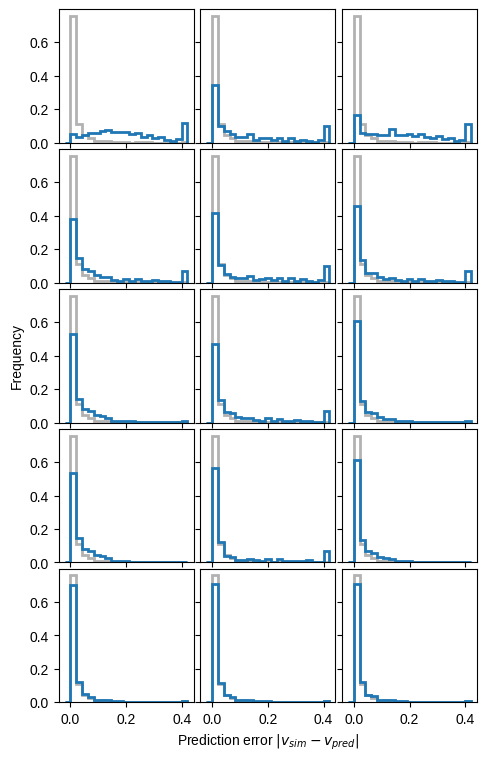

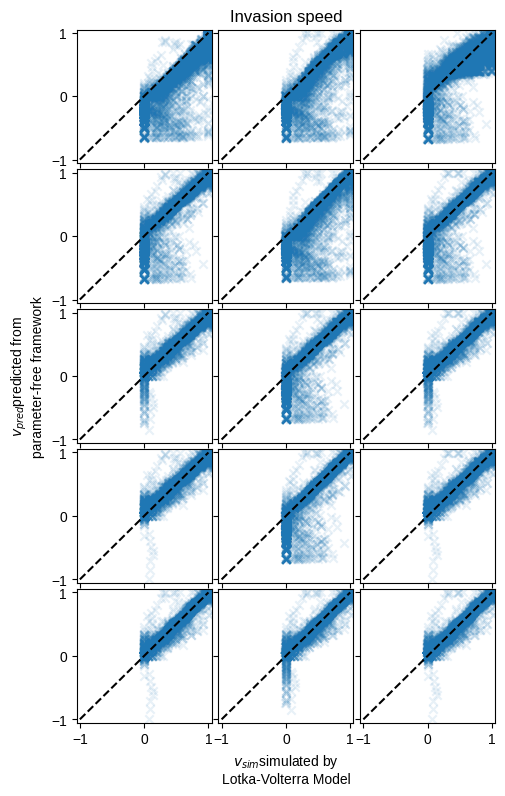

In [46]:
bin_width = 0.02
bin_range = [0, 0.4]

fig, axes = plt.subplots(5, 3, figsize=[3 * 1.8, 5 * 1.8], sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.05, wspace=0.05)
fig2, axes2 = plt.subplots(5, 3, figsize=[3 * 1.8, 5 * 1.8], sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.05, wspace=0.05)

color_list = mpl.colormaps['tab10']([1, 0, 4, 7])
n_test = len(subset_list)
for isubset in range(n_test):
    data = np.abs(mean_vn_sim - vn_pred_partial_curve[:, :, :, isubset])
    hist_data = np.histogram(data, bins=np.linspace(*bin_range, int((bin_range[1] - bin_range[0]) / bin_width)))
    counts = hist_data[0]
    bins = hist_data[1]
    counts = np.concatenate([[np.sum(data < bin_range[0])], counts, [np.sum(data >= bin_range[1])]])
    bins = np.concatenate([[bin_range[0] - bin_width], bins, [bin_range[1] + bin_width]])
    if isubset == 0:
        for ii in range(n_test - 1):
            axes.flatten()[ii].stairs(counts / counts.sum(), bins, lw=2, color='k', alpha=0.3)
    else:
        plt.sca(axes.flatten()[isubset - 1])
        plt.stairs(counts / counts.sum(), bins, lw=2, color=mpl.colormaps['tab10'](0))
        # annotate with alginment by the lower left corner of the text
        plt.annotate('Initial invader:\n' +
                     '\n'.join([str(x) for x in var_dict['ini_mixfrac'][subset_list[isubset][1:-1]]]),
                     (0.1, 0.8), ha='left', va='top')  # xycoords='axes fraction', 
        # # annotate median, 95% CI, R2
        # is_nan = np.isnan(data)
        # plt.annotate(f'median: {np.median(data):.2f}\n'
        #              f'95% CI: [{np.percentile(data, 2.5):.2f}, {np.percentile(data, 97.5):.2f}]\n'
        #              f'$R^2$: {r2_score(mean_vn_sim[~is_nan].flatten(), vn_pred_partial_curve[:, :, :, isubset][~is_nan].flatten()):.2f}\n'
        #              f'(N={np.sum(is_nan)})',
        #              (0.1, 0.4))
        if isubset == n_test - 2:
            plt.xlabel('Prediction error $|v_{sim} - v_{pred}|$')
        if isubset == 3 * 2 + 1:
            plt.ylabel('Frequency')
        
        plt.sca(axes2.flatten()[isubset - 1])
        plt.scatter(mean_vn_sim, vn_pred_partial_curve[:, :, :, isubset], marker='x', alpha=0.1)
        plt.plot([-1, 1], [-1, 1], 'k--')
        plt.xlim([-1.05, 1.05])
        plt.ylim([-1.05, 1.05])
        if isubset == n_test - 2:
            plt.xlabel('$v_{sim} $'f'simulated by\n{model_full}')
        if isubset == 3 * 2 + 1:
            plt.ylabel('$v_{pred}$'f'predicted from\nparameter-free framework')
        if isubset == 2:
            plt.title('Invasion speed')
# fig.savefig(f'./figures/sup4_pred_from_modified_curve_{model}mod.svg', bbox_inches='tight')
# fig2.savefig(f'./figures/sup4_pred_from_modified_curve_err_{model}mod.png', bbox_inches='tight', dpi=600)

## Sup Fig. 17-19

/tmp/ipykernel_303838/420586634.py:179: RuntimeWarning: divide by zero encountered in divide
  x = np.where(mask, (f_0 - f_thre) / (f_0 - f_1) * (x_1 - x_0) + x_0, np.nan)


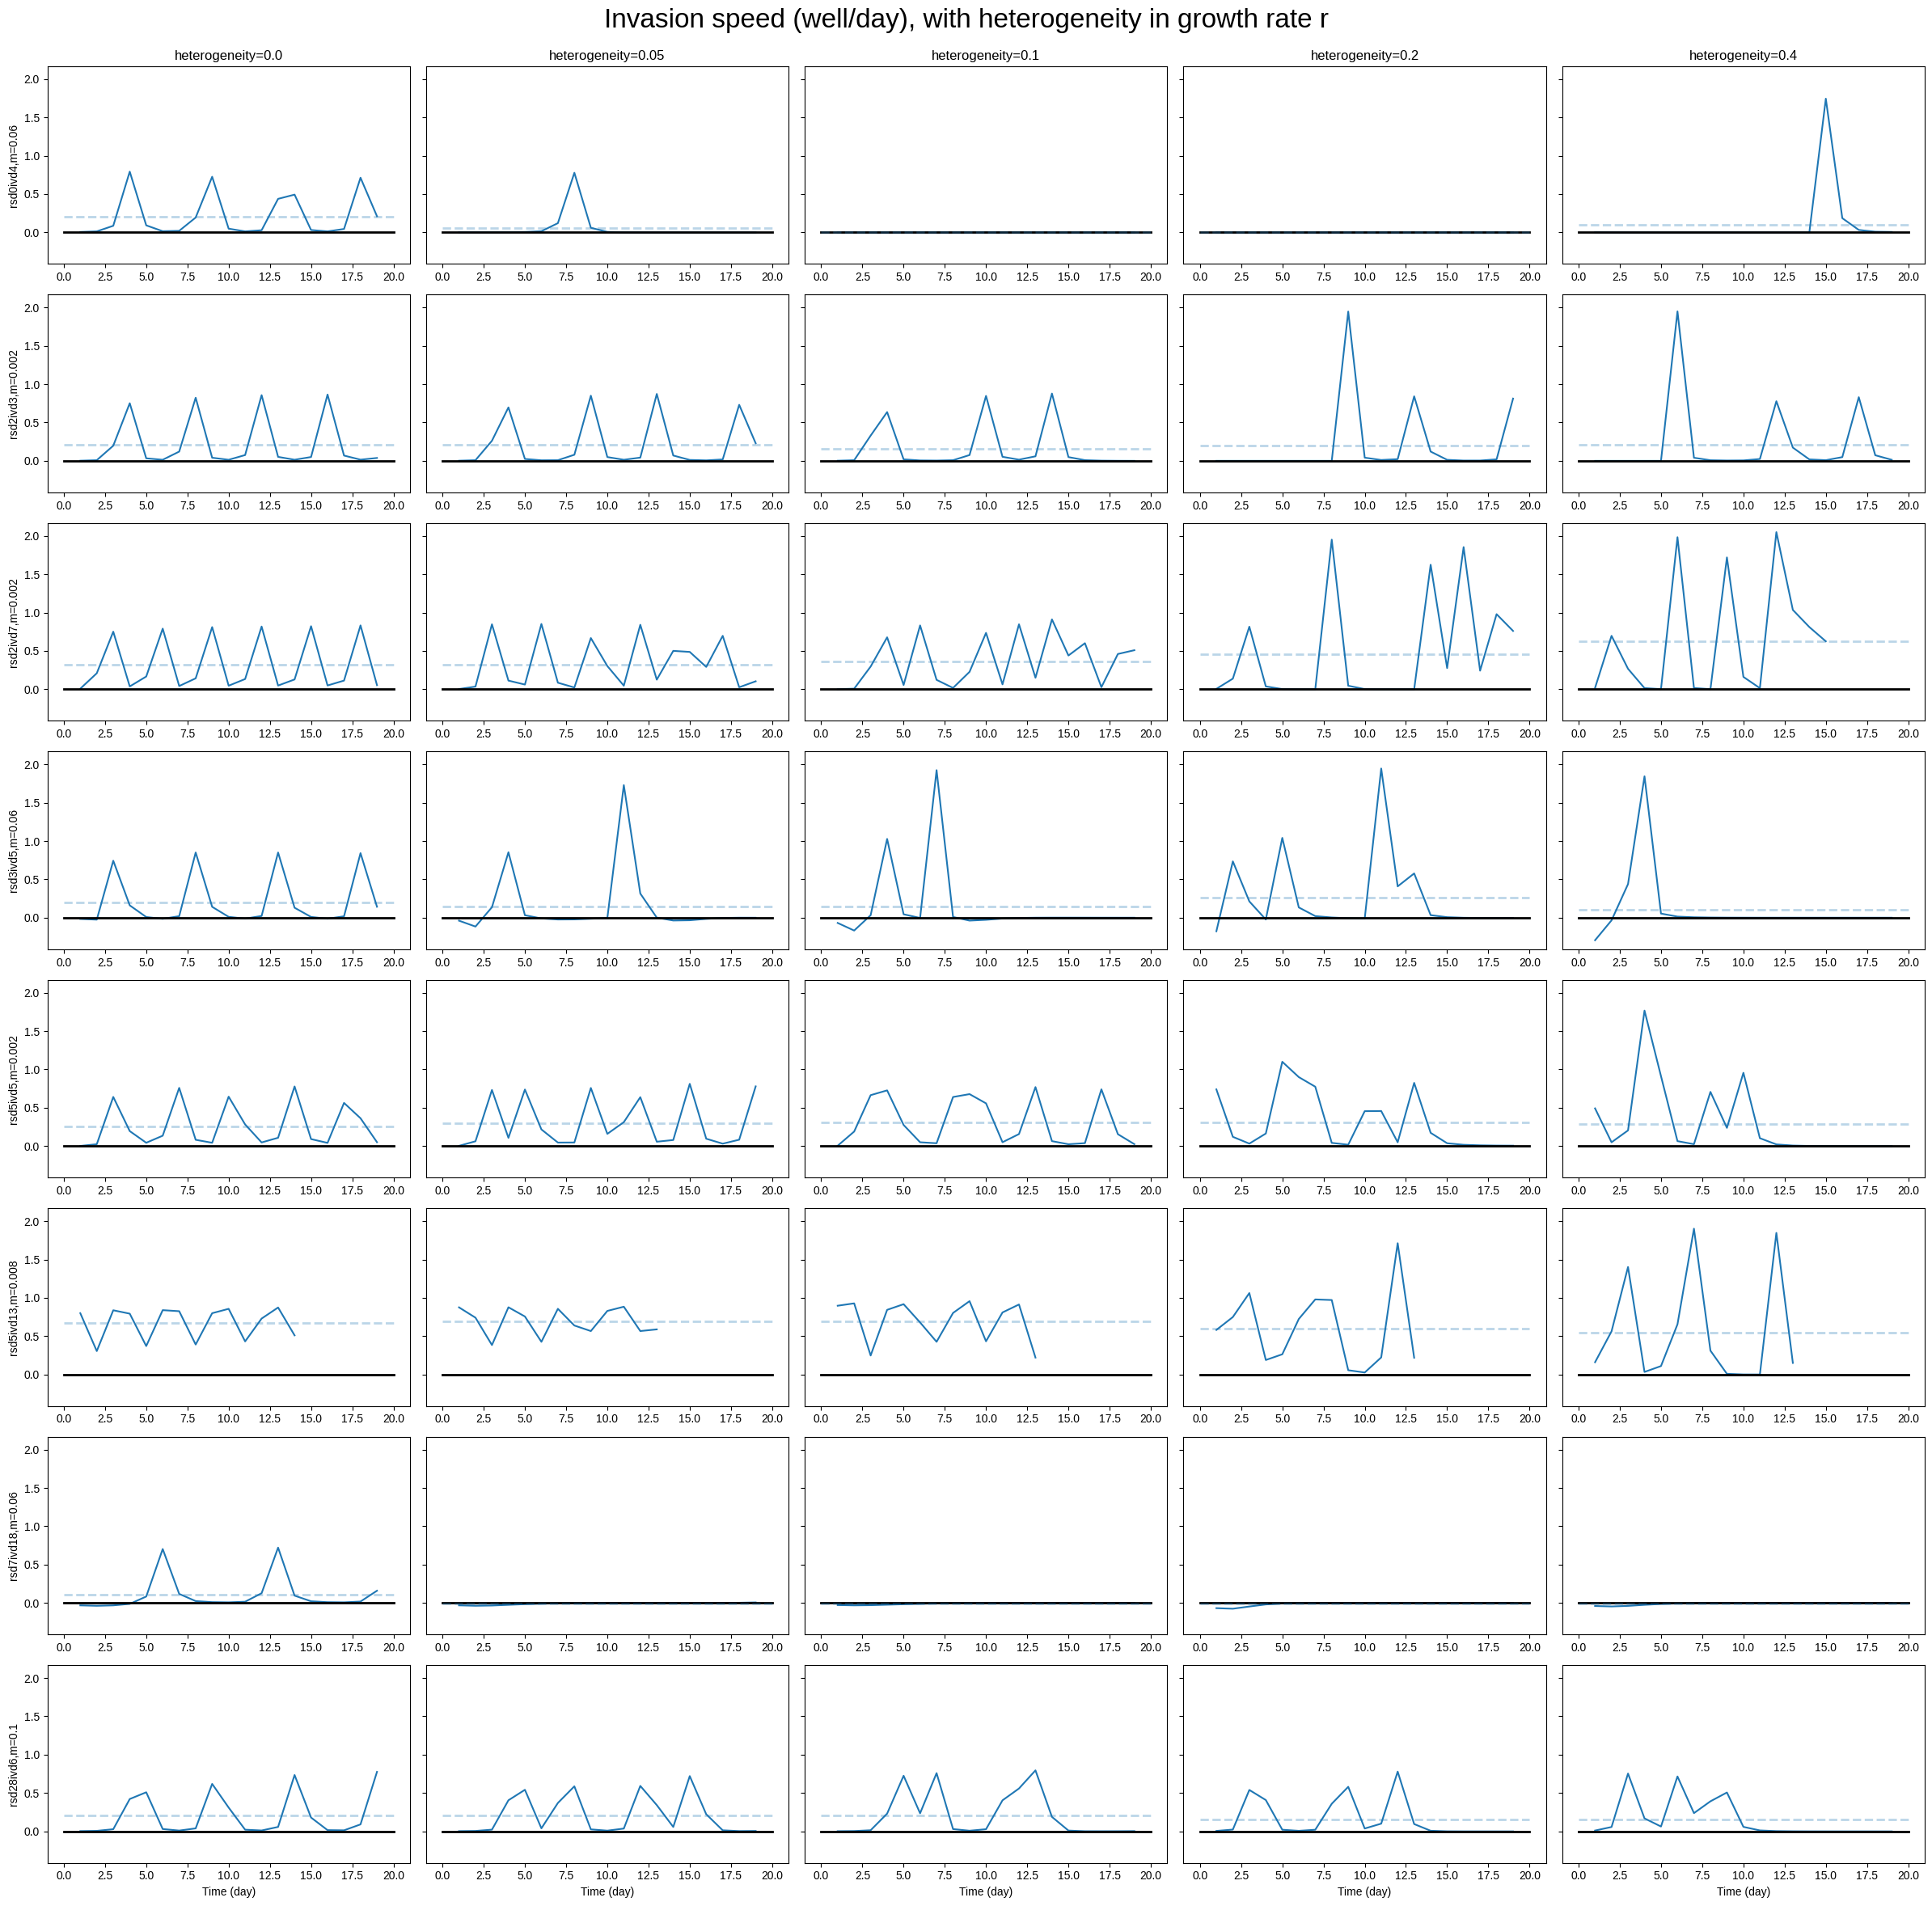

In [17]:
model = 'lv'

# examples of pulsed invasions for testing the impact of patch heterogenity
idx_explist = [[0, 4, 4],
[2, 3, 0],
[2, 7, 0],
[3, 5, 4],
[5, 5, 0],
[5, 13, 1],
[7, 18, 4],
[28, 6, 5]]

# summarize results for each heterogenity treatment (m, K, r), take ['result'] from each idx_explist
irsd, iivd = idx_explist[0][:2]
with open(f'./{model}/sum_heterpatch_mod2inv_rsd{irsd}_ivd{iivd}.pkl', 'rb') as f:
        data_rand = pickle.load(f)
        noise_list = data_rand['noise_list']
        m_list = data_rand['m_list']
sum_heter_m = np.zeros((len(idx_explist), len(noise_list)), dtype='object')
sum_heter_K = np.zeros((len(idx_explist), len(noise_list)), dtype='object')
sum_heter_r = np.zeros((len(idx_explist), len(noise_list)), dtype='object')
for iexp in range(len(idx_explist)):
    irsd, iivd = idx_explist[iexp][:2]
    with open(f'./lv/sum_heterpatch_mod2inv_rsd{irsd}_ivd{iivd}.pkl', 'rb') as f:
        data_rand = pickle.load(f)
        noise_list = data_rand['noise_list']
        m_list = data_rand['m_list']
        sum_heter_m[iexp] = [data_rand['res_heter_m'][ik]['result'] for ik in range(len(noise_list))]
        sum_heter_K[iexp] = [data_rand['res_heter_K'][ik]['result'] for ik in range(len(noise_list))]
        sum_heter_r[iexp] = [data_rand['res_heter_r'][ik]['result'] for ik in range(len(noise_list))]

# calculate invasion speed
nday = 21
vn_all_heter_m = np.zeros((len(idx_explist), len(noise_list), len(m_list), nday))
vn_all_heter_K = np.zeros((len(idx_explist), len(noise_list), len(m_list), nday))
vn_all_heter_r = np.zeros((len(idx_explist), len(noise_list), len(m_list), nday))
for iexp in range(len(idx_explist)):
    for ii in range(len(noise_list)):
        for im in range(len(m_list)):
            vn_all_heter_m[iexp, ii, im] = calc_inv_speed(sum_heter_m[iexp][ii][im, :, :, 0] / sum_heter_m[iexp][ii][im, :, :, :-1].sum(axis=-1), 0.5)
            vn_all_heter_K[iexp, ii, im] = calc_inv_speed(sum_heter_K[iexp][ii][im, :, :, 0] / sum_heter_K[iexp][ii][im, :, :, :-1].sum(axis=-1), 0.5)
            vn_all_heter_r[iexp, ii, im] = calc_inv_speed(sum_heter_r[iexp][ii][im, :, :, 0] / sum_heter_r[iexp][ii][im, :, :, :-1].sum(axis=-1), 0.5)
            # vn_all_heter_m[iexp, ii, im] = calc_inv_speed_area(sum_heter_m[iexp][ii][im, :, :, 0] / sum_heter_m[iexp][ii][im, :, :, :-1].sum(axis=-1))
            # vn_all_heter_K[iexp, ii, im] = calc_inv_speed_area(sum_heter_K[iexp][ii][im, :, :, 0] / sum_heter_K[iexp][ii][im, :, :, :-1].sum(axis=-1))
            # vn_all_heter_r[iexp, ii, im] = calc_inv_speed_area(sum_heter_r[iexp][ii][im, :, :, 0] / sum_heter_r[iexp][ii][im, :, :, :-1].sum(axis=-1))

# plot invasion speed, only for chosen m as in idx_explist
# for each of m, K, r, plot a len(idx_explist) x len(noise_list) subplot
fig, axes = plt.subplots(len(idx_explist), len(noise_list), figsize=(24, 24), sharey=True)
for iheter in range(3):
    vn_all_heter_curr = [vn_all_heter_m, vn_all_heter_K, vn_all_heter_r][iheter]
    for iexp in range(len(idx_explist)):
        irsd, iivd, im = idx_explist[iexp]
        for ii in range(len(noise_list)):
            plt.sca(axes[iexp, ii])
            plt.cla()
            plt.plot(np.arange(nday), vn_all_heter_curr[iexp, ii, im].T)
            plt.plot([0, nday - 1], [0, 0], 'k', linewidth=2)
            plt.plot([0, nday - 1], np.nanmean(vn_all_heter_curr[iexp, ii, im], axis=0) * np.ones(2), '--', color=mpl.colormaps['tab10'](0), alpha=0.3, linewidth=2)
            # plt.title(f'rsd{irsd}ivd{iivd},m={m_list[im]}, heterogeneity={noise_list[ii]}')
            if iexp == 0:
                plt.title(f'heterogeneity={noise_list[ii]}')
            if ii == 0:
                plt.ylabel(f'rsd{irsd}ivd{iivd},m={m_list[im]}')
            if iexp == len(idx_explist) - 1:
                plt.xlabel('Time (day)')
    plt.tight_layout()
    # plt.ylim([-0.05, 1.05])
    fig.suptitle(f'Invasion speed (well/day), with heterogeneity in {["dispersal rate m", "carrying capacity K", "growth rate r"][iheter]}', fontsize=24)
    fig.subplots_adjust(top=0.95)
    # fig.savefig(f'./figures_nc_round1/inv_speed_heter_{["m", "K", "r"][iheter]}.png', dpi=300)